**This notebook will examine and attempt to predict the factors that cause employees to leave their employment. **

In [16]:
#Let's import everything we will need
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output
import warnings
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')

%matplotlib inline

In [2]:
#Read the csv file and create feature / label sets
X = pd.read_csv('HR_comma_sep.csv')
X.head()

y = X['left']

print('Number of records: ', X.shape[0])

Number of records:  14999


In [3]:
X.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# Part 1 - explore the data

Let's look at our dataset first:

Let's check for missing data:

In [4]:
X.isnull().values.ravel().sum()

0

Good, we don't have any missing values

Now, let's check the data types:


In [5]:
X.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
Department                object
salary                    object
dtype: object

We will need the salary column for our analysis, so let's map it appropriately:



In [6]:
X.salary.unique()

array(['low', 'medium', 'high'], dtype=object)

In [7]:
X.salary.replace({'low':1,'medium':2,'high':3},inplace=True)

Now, let's perform some simple statistics to better understand the data:

In [8]:
X.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,1.594706
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,0.637183
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,1.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,1.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,2.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,2.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,3.000000


# Part 2 - visualize the data
Let's look at the correlation matrix now:

Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

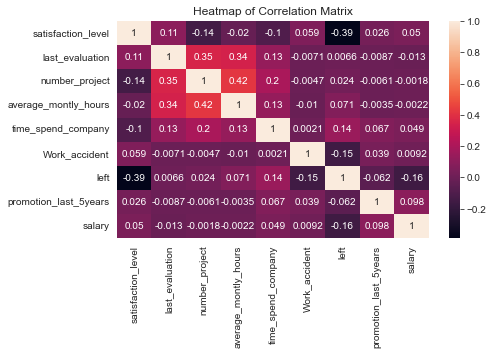

In [9]:
fig = plt.figure(figsize=(7,4))
corr = X.corr()
sns.heatmap(corr,annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')

There seems to be a clear inverse relation between satisfaction levels and people leaving




We will now visualize the distribution of several features of interest using a histogram or a kernel density estimate plot.

Let's look the the average monthly hours distribution for those that left:

Text(0.5, 1.0, 'Satisfaction levels')

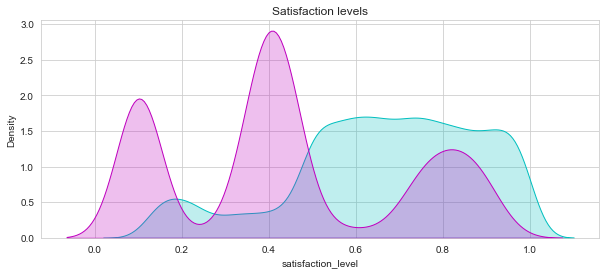

In [10]:
#produce kernel density estimate plots and histograms to look at each feature
fig = plt.figure(figsize=(10,4))
ax=sns.kdeplot(X.loc[(X['left'] == 0),'satisfaction_level'] , color='c',shade=True, label='Stayed')
ax=sns.kdeplot(X.loc[(X['left'] == 1),'satisfaction_level'] , color='m',shade=True, label='Left')
plt.title('Satisfaction levels')

People who have left were in general less satisfied with their jobs. However there are also people who are quite satisfied with their jobs but still left. This means that there are other factors contributing to an employee leaving their job other than them being satisfied with their job or not. satisfaction_level` seems to be a good feature in differentiating people who left the company from people who did not leave.

Text(0.5, 1.0, 'Last evaluation')

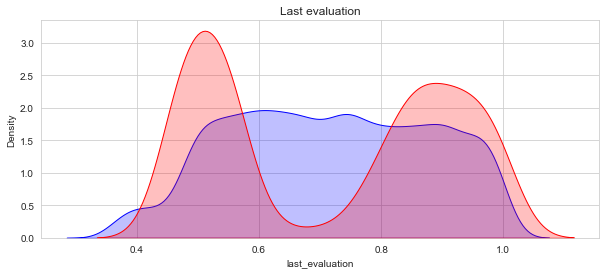

In [11]:
#produce kernel density estimate plots and histograms to look at each feature
fig = plt.figure(figsize=(10,4),)
ax=sns.kdeplot(X.loc[(X['left'] == 0),'last_evaluation'] , color='b',shade=True,label='Stayed')
ax=sns.kdeplot(X.loc[(X['left'] == 1),'last_evaluation'] , color='r',shade=True, label='Left')
plt.title('Last evaluation')

Looks like people who leave the company either did pretty bad or pretty good in their last performance evaluation. There are not many medium level performers among the people who left. If an employee is evaluated in the range of 0.6 to 0.8 (ball park), they are likely still working in the company.

Text(0.5, 1.0, 'Number of projects')

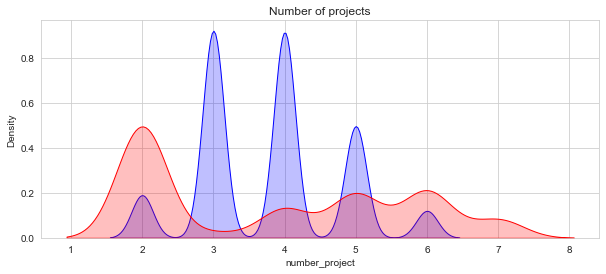

In [12]:
#produce kernel density estimate plots and histograms to look at each feature
fig = plt.figure(figsize=(10,4))
ax=sns.kdeplot(X.loc[(X['left'] == 0),'number_project'] , color='b',shade=True, label= 'Stayed')
ax=sns.kdeplot(X.loc[(X['left'] == 1),'number_project'] , color='r',shade=True, label= 'Left')
plt.title('Number of projects')

People who left mostly work on a small number of projects (2), or on a large number of projects (5-7). I added a new feature: number of projects worked on per year. I defined this as the number of projects the employee works on during his/her employment period, divided by the total number of years the employee worked in the company. People who left mostly work on a lower number of projects per year when compare to the employees who have not left.

Text(0.5, 1.0, 'Average monthly hours worked')

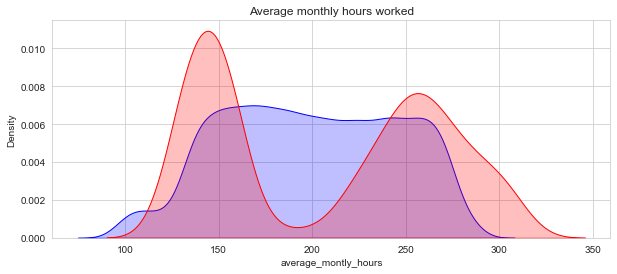

In [13]:
#produce kernel density estimate plots and histograms to look at each feature
fig = plt.figure(figsize=(10,4))
ax=sns.kdeplot(X.loc[(X['left'] == 0),'average_montly_hours'] , color='b',shade=True, label='Stayed')
ax=sns.kdeplot(X.loc[(X['left'] == 1),'average_montly_hours'] , color='r',shade=True, label='Left')
plt.title('Average monthly hours worked')

People who left either work a small amount of hours on average per month (lower than 150 hours), or they work a large number of hours (more than 250). This means that the employees who leave tend to either not work much or work a lot. The fact that employees who leave are evaluated either bad or quite good in their last performance evaluation might be related to this fact.

Text(0.5, 1.0, 'Salary: (1-Low; 2-Medium; 3-high)')

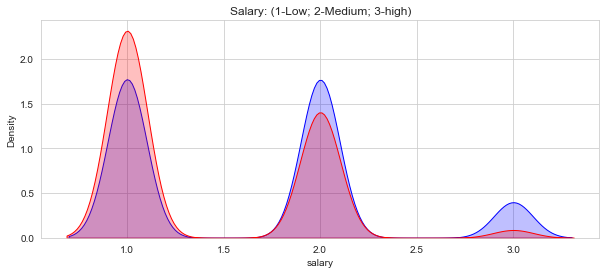

In [14]:
#produce kernel density estimate plots and histograms to look at each feature
fig = plt.figure(figsize=(10,4))
ax=sns.kdeplot(X.loc[(X['left'] == 0),'salary'] , color='b',shade=True, label='Stayed')
ax=sns.kdeplot(X.loc[(X['left'] == 1),'salary'] , color='r',shade=True, label='Left')
plt.title('Salary: (1-Low; 2-Medium; 3-high)')

We can clearly spot a trend here - the higher the salary, the lower the chances of employees leaving. 

<AxesSubplot:xlabel='time_spend_company', ylabel='left'>

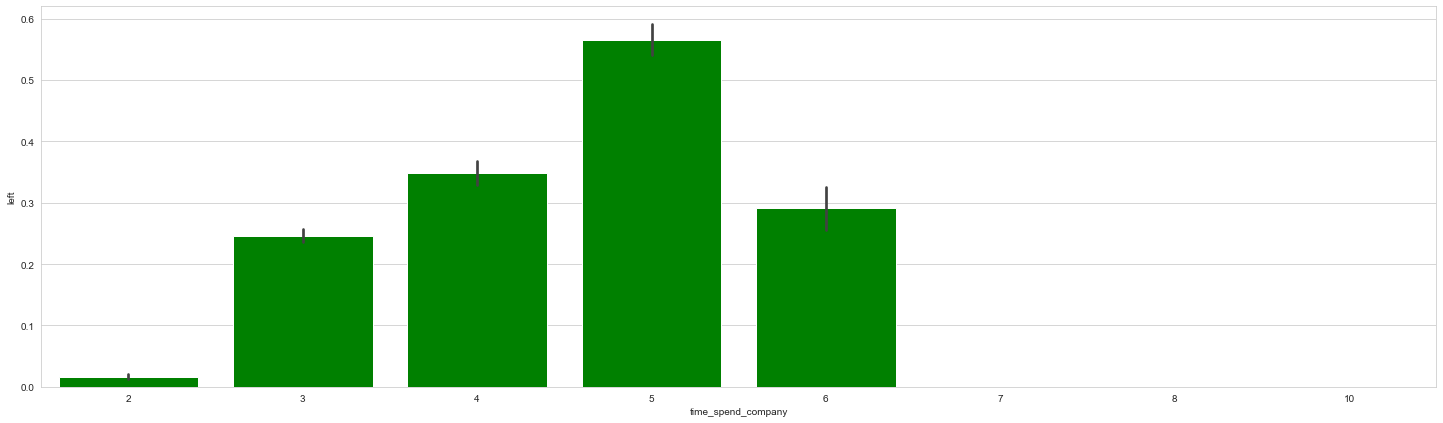

In [15]:
fig = plt.figure(figsize=(25,7),)
sns.barplot(x = 'time_spend_company', y = 'left',color='green',saturation=1, data = X)

The majority of employees tend to leave around the 5th year. 